

# <span style="color:#ff5f27;"> 🧑🏻‍🏫 Great Expectations </span>


Great Expectations is the leading tool for validating, documenting, and profiling your data to maintain quality and improve communication between teams. Head over to our getting started tutorial.

Software developers have long known that automated testing is essential for managing complex codebases. Great Expectations brings the same discipline, confidence, and acceleration to data science and data engineering teams.

With Great Expectations, you can assert what you expect from the data you load and transform, and catch data issues quickly – Expectations are basically unit tests for your data. Not only that, but Great Expectations also creates data documentation and data quality reports from those Expectations.

To begin with, let's install `great_expectations` library.

In [1]:
#!pip install great_expectations -U -qqq

Then - import `great_expectations` library and define `ExpectationSuite`

- `Expectations` are the workhorse abstraction in Great Expectations. Each Expectation is a declarative, machine-verifiable assertion about the expected format, content, or behavior of your data. Great Expectations comes with dozens of built-in Expectations, and it’s possible to develop your own custom Expectations, too.

- `ExpectationSuite` - a collection of `Expectations` about data which you will use when you **Validate** data.

Then create `Expectations`.

You can create them using `ge.core.ExpectationConfiguration()` function with next parameters:

- **expectation_type** - specify the [name of expectations](https://greatexpectations.io/expectations/) you need.

- **kwargs** - specify keyword arguments of this Expectation Type.

Then you should add some expectation to your suite to validate columns.

You can do it by using `expectation_suite.add_expectation()` method.

## <span style="color:#ff5f27;"> 📝 Imports</span>

In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
from hops import hdfs

project_path = hdfs.project_path()

project_path

'hdfs://rpc.namenode.service.consul:8020/Projects/electricity/'

## <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [4]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;">🧑🏻‍🏫 Functions</span>

In [5]:
def get_data(data_path):
    df = pd.read_csv(data_path,
        index_col = 0,
        parse_dates = ['date']
    ).dropna()
    return df    


def timestamp_2_time(x):
    dt_obj = datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
    dt_obj = dt_obj.timestamp() * 1000
    return dt_obj


def to_date(unix):
    return datetime.utcfromtimestamp(unix / 1000).strftime('%Y-%m-%d %H:%M:%S')


def feature_engineering(df):
    windows = [7,14,30]
    for window in windows:
        df[f'demand_{window}_mean'] = df.demand.rolling(window = window).mean()
        df[f'demand_{window}_std'] = df.demand.rolling(window = window).std()
    if type(df.date[0]) != np.int64:
        df.date = df.date.apply(lambda x: timestamp_2_time(str(x)[:19])).astype(np.int64)
    df.dropna(inplace=True)
    return df


def create_feature_group(data = None,name='electricity_fg',fs=fs):
    import great_expectations as ge
    
    expectation_suite = ge.core.ExpectationSuite(
        expectation_suite_name="Expectation Suite for Electricity Feature Group"
    )
    expectation = ge.core.ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={
             "column": "date",
             "mostly": 1.0
         }
    )
    expectation_suite.add_expectation(expectation)
    
    feature_group = fs.get_or_create_feature_group(
        name=name,
        description = 'Daily Electricity Price and Demand',
        version = 1,
        primary_key = ['index'],
        online_enabled = True,
        event_time = ['date'],
        expectation_suite=expectation_suite
    )
        
    feature_group.insert(data.reset_index())
    
    return feature_group


def retrieve_feature_group(name='electricity_fg',fs=fs):
    feature_group = fs.get_feature_group(
        name=name,
        version=1
    )
    return feature_group

## <span style="color:#ff5f27;">🪄 👩🏻‍🔬 Retrieving or Creating Feature Group</span>

In [6]:
try:
    feature_group = retrieve_feature_group()
    df_electricity = feature_group.read()
    df_electricity.sort_values('date',inplace=True)
    indexes = df_electricity.pop('index')
    
except: 
    DATA_PATH = project_path + 'Jupyter/data/electricity.csv'
    
    df_electricity = get_data(DATA_PATH)
    feature_engineering(df_electricity)
    
    feature_group = create_feature_group(df_electricity)

Feature Group created successfully, explore it at 
https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/fs/68/fg/4115
2022-08-22 08:31:38,359 INFO: 	1 expectation(s) included in expectation_suite.
Validation Report saved successfully, explore a summary at https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/fs/68/fg/4115


Uploading Dataframe: 0.00% |          | Rows 0/2077 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/jobs/named/electricity_fg_1_offline_fg_backfill/executions


In [7]:
df_electricity.head()

,date,RRP,frac_at_neg_RRP,demand,RRP_positive,demand_neg_RRP,RRP_negative,demand_pos_RRP,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
29,1422576000000,21.029356,0.0,121018.15,21.029356,0.0,0.0,121018.15,113361.206429,8840.007476,119750.684643,17637.057172,121135.323333,16463.479261
30,1422662400000,16.538847,0.0,103822.97,16.538847,0.0,0.0,103822.97,111577.260714,9388.612319,120068.660357,17277.849041,121274.921333,16291.746026
31,1422748800000,14.578844,0.0,100178.84,14.578844,0.0,0.0,100178.84,111894.315000,8875.547703,120243.666786,17045.002549,120294.015667,16654.688684
32,1422835200000,22.270032,0.0,118694.16,22.270032,0.0,0.0,118694.16,114026.412143,8377.113294,120373.024643,17024.396712,119507.136333,16128.447829
33,1422921600000,27.003832,0.0,122880.13,27.003832,0.0,0.0,122880.13,114667.386429,8920.937447,119938.167857,16864.969397,120125.450167,15880.221937


## <span style="color:#ff5f27;">🕵🏻‍♂️ Data Exploration</span>

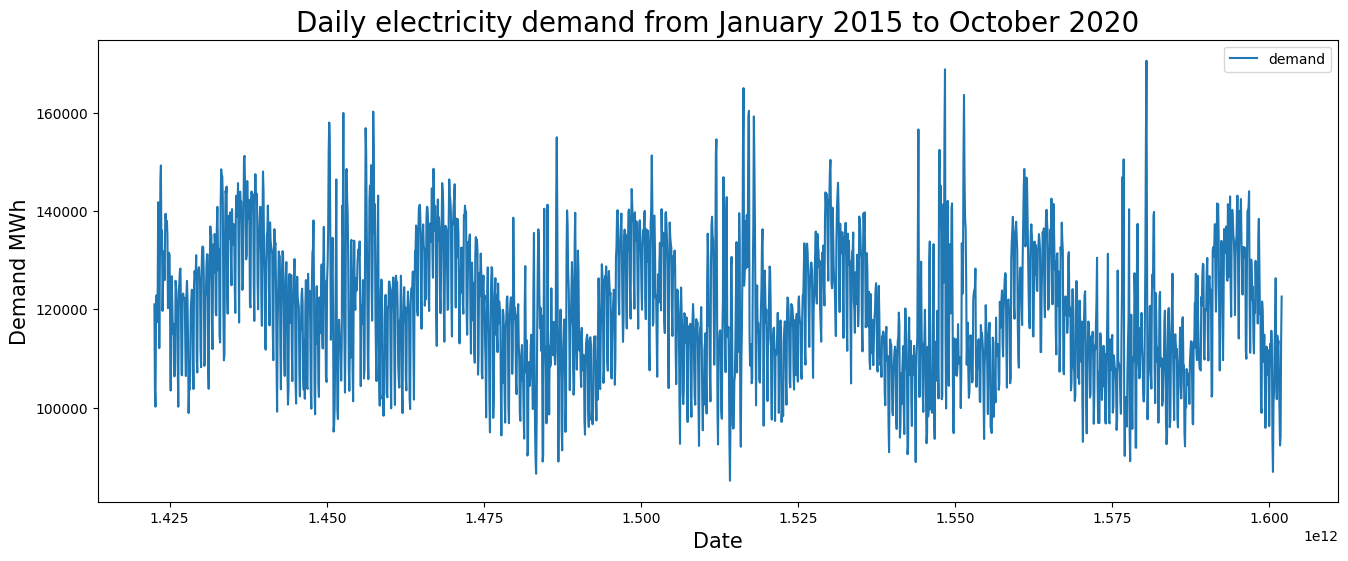

In [8]:
fig,ax = plt.subplots(figsize = (16,6))

df_electricity.plot('date','demand', ax = ax)

ax.set_xlabel('Date',fontsize = 15)
ax.set_ylabel('Demand MWh',fontsize = 15)
ax.set_title('Daily electricity demand from January 2015 to October 2020',fontsize = 20)

plt.show()

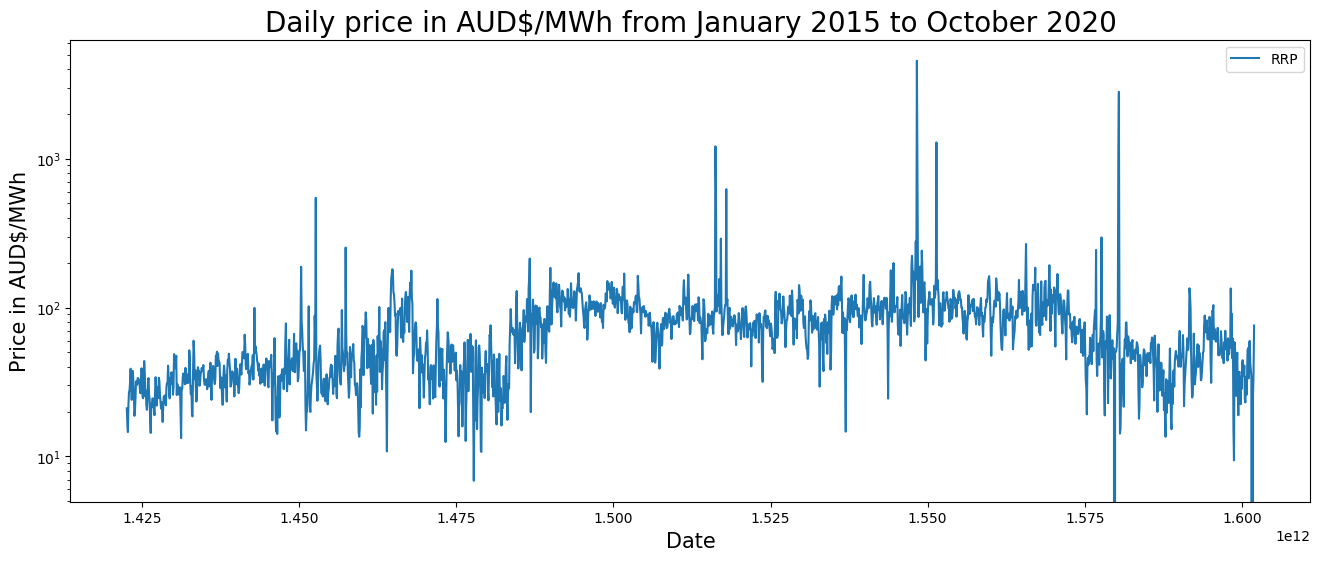

In [9]:
fig,ax = plt.subplots(figsize = (16,6))

try:
    df_electricity.plot('date','RRP', ax = ax)
except:
    df_electricity.plot('date','rrp', ax = ax)
    
ax.set_xlabel('Date',fontsize = 15)
ax.set_ylabel('Price in AUD$/MWh',fontsize = 15)
ax.set_title('Daily price in AUD$/MWh from January 2015 to October 2020',fontsize = 20)

plt.yscale("log")
plt.show()

## <span style="color:#ff5f27;">🧬 Data Generation</span>

In [10]:
def get_statistics(feature):
    mean = feature.mean()
    lower_value,upper_value = mean - feature.std() * 3,mean + feature.std() * 3
    return lower_value,upper_value

In [11]:
statistics = {col:get_statistics(df_electricity[col]) for col in df_electricity.columns[1:]}

date_window = 24*60*60*1000

In [12]:
def generate_observation(statistics):
    return [round(random.uniform(lower_value, upper_value),1) for lower_value, upper_value in statistics.values()]

def generate_data(df,amount = 1,date_window = date_window,statistics=statistics):
    df_last = df.sort_values('date').date.iloc[-1]
    df_generated = pd.DataFrame(columns = ['date',*statistics.keys()])
    for i in range(1, amount + 1):
        df_generated.loc[len(df_generated)] = [df_last + date_window * i,*generate_observation(statistics)]
    return df_generated.astype({'date':int})

def append_generated_data(df,amount = 1,date_window = date_window,statistics=statistics):
    df_last = df.sort_values('date').date.iloc[-1]
    for i in range(1, amount + 1):
        df.loc[len(df)] = [df_last + date_window,*generate_observation(statistics)]
    df.date = df.date.apply(int)
    return df

In [13]:
append_generated_data(df_electricity,50)

df_electricity.tail()

,date,RRP,frac_at_neg_RRP,demand,RRP_positive,demand_neg_RRP,RRP_negative,demand_pos_RRP,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
2101,1601596800000,-6.076028,0.625000,99585.835,26.980251,57597.595,-30.173823,41988.240,107853.412857,5863.497206,106837.896429,10252.098113,107616.556667,8207.955310
2102,1601683200000,-1.983471,0.583333,92277.025,32.438156,48143.515,-33.538025,44133.510,105793.707143,8345.345417,106758.826786,10367.463245,107048.208833,8663.098205
2103,1601769600000,25.008614,0.062500,94081.565,26.571687,5500.570,-0.163066,88580.995,104704.860714,9398.705870,107272.422143,9444.552624,106355.406167,8845.515370
2104,1601856000000,36.764701,0.083333,113610.030,39.616015,7022.655,-6.511550,106587.375,104556.130714,9221.648048,108174.713571,9400.251805,106624.606833,8942.019999
2105,1601942400000,75.771059,0.000000,122607.560,75.771059,0.000,0.000000,122607.560,106060.573571,11281.903392,109560.922143,10020.767478,107516.020833,9162.671696


## <span style="color:#ff5f27;">👩🏻‍⚖️ 🪄 Validation and Insertion of Generated Data</span>

In [14]:
def add_indexes(df,indexes=None):
    if indexes is None:
        return df.reset_index()
    df.reset_index(inplace = True)
    df['index'] = df['index'] + indexes.max() + 1
    return df

In [15]:
generated_data = generate_data(df_electricity,50)
feature_engineering(generated_data)

try: 
    generated_data = add_indexes(generated_data,indexes)
except:
    generated_data = add_indexes(generated_data)

generated_data.head()

,index,date,RRP,frac_at_neg_RRP,demand,RRP_positive,demand_neg_RRP,RRP_negative,demand_pos_RRP,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
0,29,1604620800000,458.0,0.1,108407.6,389.7,-2991.1,-38.5,153312.0,111301.814286,24365.291057,114059.157143,25092.252248,119182.763333,23818.603332
1,30,1604707200000,201.0,-0.0,114431.5,-303.3,5290.9,11.4,161163.4,113844.157143,23492.702143,112435.585714,24202.020278,120055.523333,23115.345705
2,31,1604793600000,116.4,0.1,131677.5,438.3,-689.5,-39.9,134590.6,110540.100000,17678.558144,112565.128571,24307.107855,121197.373333,22802.704260
3,32,1604880000000,300.9,-0.1,98209.1,141.6,4790.4,33.7,115660.6,110721.871429,17521.217099,112521.435714,24334.248833,120467.416667,23186.072487
4,33,1604966400000,346.6,0.0,143003.7,215.9,-6461.8,-1.3,152148.4,111868.828571,19522.004369,116908.585714,23859.497749,121612.096667,23429.617928


In [16]:
feature_group.insert(generated_data)

2022-08-22 08:32:34,675 INFO: 	1 expectation(s) included in expectation_suite.
Validation Report saved successfully, explore a summary at https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/fs/68/fg/4115


Uploading Dataframe: 0.00% |          | Rows 0/21 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/jobs/named/electricity_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7f3c15ad6ac0>,
 {
   "evaluation_parameters": {},
   "meta": {
     "great_expectations_version": "0.14.3",
     "expectation_suite_name": "Expectation Suite for Electricity Feature Group",
     "run_id": {
       "run_time": "2022-08-22T08:32:34.675472+00:00",
       "run_name": null
     },
     "batch_kwargs": {
       "ge_batch_id": "f8b5bbcc-21f4-11ed-9269-bea944458058"
     },
     "batch_markers": {},
     "batch_parameters": {},
     "validation_time": "20220822T083234.675418Z",
     "expectation_suite_meta": {
       "great_expectations_version": "0.14.3"
     }
   },
   "results": [
     {
       "result": {
         "element_count": 21,
         "unexpected_count": 0,
         "unexpected_percent": 0.0,
         "unexpected_percent_total": 0.0,
         "partial_unexpected_list": []
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       },
       "meta":